# 🧪 NMR Deep Learning Enhancement Project 🚀

## ✅ Goals & To-Dos

1. **Prepare FID Data** 📊  
   - Load raw FID using `nmr.load_fid_and_preview`  
   - Normalize and format for PyTorch `(batch, 1, length)`  

2. **Build DL Model** 🤖  
   - 1D Convolutional Autoencoder or Dilated Conv Network  
   - Input: raw FID  
   - Output: enhanced / denoised FID  

3. **Train Model** 🏋️‍♂️  
   - Start with **simulated FIDs** (damped sinusoids + noise)  
   - Later fine-tune on **experimental FIDs**  

4. **Integrate With Existing Pipeline** 🔗  
   - Feed `enhanced_FID` into `compute_fft_spectrum`  
   - Run peak detection, integration, and J-coupling analysis as usual  

5. **Compare Results** 📈  
   - Original vs enhanced FID → FFT → peaks → integrals  
   - Evaluate **noise reduction, peak clarity, and acquisition efficiency**  

6. **Optional Advanced Steps** ✨  
   - End-to-end model: partial FID → predicted spectrum  
   - Explore **super-resolution/extrapolation** to reduce acquisition time  

---

💡 **Tip:** Keep the DL module modular so it can be swapped in/out without breaking existing code.  


In [9]:
import functions.nmr_function as nmr
import numpy as np

### Once me and Krish get a spectrum replace this with that FID

          X      Real  Imaginary
0  0.000000  0.000003   0.000009
1  0.000133 -0.001235  -0.003140
2  0.000267  0.050601   0.188029
3  0.000400  0.019175   0.365893
4  0.000533 -0.136525  -0.611649


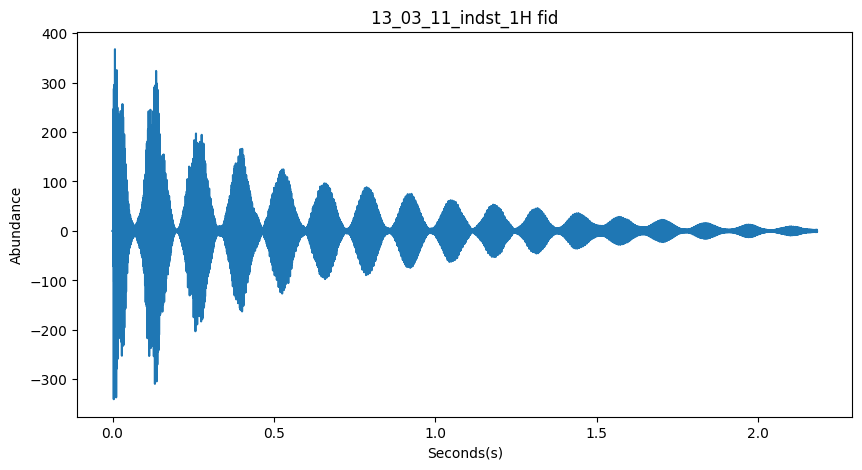

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': '13_03_11_indst_1H fid'}, xlabel='Seconds(s)', ylabel='Abundance'>)

In [10]:
url = r"https://raw.githubusercontent.com/Quintinlf/NMR-Project/main/spring_semester_2025/13_03_11_indst_1H%20fid.asc"
df, name = nmr.load_fid_and_preview(url)

# Ensure array for downstream cells
data = df if isinstance(df, np.ndarray) else df.to_numpy()

nmr.plot_fid(data, title=name, xcol=0, ycol=1, xlabel="Seconds(s)", ylabel="Abundance", invert_x=False)

Make the FID into a torch instead of a numpy array so that now You can put it into pytorch.

The output says that we are processing 1 FID, we are working with 2 chanels (real vs imaginary) , and the length of that is x (depending on the particular FID)

In [13]:
# ...existing code...
import torch
import numpy as np

sig = data[:, 1:3].astype(np.float32).T  # (2, L) -> [Real, Imag]
sig = (sig - sig.mean(axis=1, keepdims=True)) / (sig.std(axis=1, keepdims=True) + 1e-8)

fid_tensor = torch.from_numpy(sig).unsqueeze(0)  # (1,2,L)
print("fid_tensor shape:", fid_tensor.shape)
# ...existing code...

fid_tensor shape: torch.Size([1, 2, 16384])


# 🧠 Understanding the Dilated Conv FID Network

## 1️⃣ Parameters (Weights & Biases)

For a Conv1D layer:

$$
\text{Weights shape: } (C_{\text{out}}, C_{\text{in}}, K)
$$

- $C_{\text{in}}$ = input channels  
- $C_{\text{out}}$ = output channels  
- $K$ = kernel size  

**Number of weight parameters:**
$$
N_{\text{weights}} = C_{\text{out}} \times C_{\text{in}} \times K
$$

**Number of bias parameters:**
$$
N_{\text{bias}} =
\begin{cases}
C_{\text{out}} & \text{if bias exists} \\
0 & \text{otherwise}
\end{cases}
$$

**Total parameters per layer:**
$$
N_{\text{params}} = N_{\text{weights}} + N_{\text{bias}}
$$

> Example: First Conv1D: `(32, 2, 7)` → $(32 \times 2 \times 7 = 448)$ weights + 32 biases → 480 total params

---

## 2️⃣ Kernel Intuition

- Kernel = small 1D array of trainable numbers  
- Slides along FID → multiplies & sums → extracts local patterns (peaks, oscillations)  
- Each output channel has its own kernel for every input channel

---

## 3️⃣ Choosing Channels

- Input channels: $C_{\text{in}} = 2$ (Real + Imag FID)  
- Hidden channels: $C_{\text{hidden}} = 32$ (network capacity hyperparameter)  
- Output channels: same as input ($C_{\text{out}} = 2$)  

---

## 4️⃣ Dilation & Effective Kernel

**Dilation** = spacing between kernel elements:

$$
\text{Effective kernel size: } K_{\text{eff}} = D \cdot (K - 1) + 1
$$

- $D$ = dilation factor  
- $K_{\text{eff}}$ = how many original FID points a single output “sees”  
- Cumulative receptive field adds contributions from each layer:  

$$
\text{cum\_RF}_{i} = \text{cum\_RF}_{i-1} + K_{\text{eff}} - 1
$$

> Your network final layer sees 385 points of the original FID.

---

## 5️⃣ Residual Connections

- Each `DilatedResBlock` predicts a **residual**:  

$$
\text{output} = x + \text{residual}(x)
$$

- Helps learning: network focuses on **correcting noise** rather than recreating FID from scratch

---

## 6️⃣ Visual Intuition

- Input: FID `(batch, channels, length)`  
- Layers: conv1 → residual blocks → out  
- Each block expands **receptive field** via dilation  
- Visual: each ■ = output channel  

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DilatedResBlock(nn.Module):
    def __init__(self, channels, dilation=1, k=7):
        super().__init__()
        pad = dilation * ((k - 1) // 2)
        self.conv1 = nn.Conv1d(channels, channels, k, padding=pad, dilation=dilation)
        self.conv2 = nn.Conv1d(channels, channels, k, padding=pad, dilation=dilation)

    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = self.conv2(h)
        return F.relu(x + h)

class DenoiseNet(nn.Module):
    def __init__(self, in_ch=2, hidden=32, k=7, dilations=(1,2,4,8,16)):
        super().__init__()
        self.inp = nn.Conv1d(in_ch, hidden, k, padding=(k-1)//2)
        self.blocks = nn.Sequential(*[DilatedResBlock(hidden, d, k) for d in dilations])
        self.out = nn.Conv1d(hidden, in_ch, k, padding=(k-1)//2)  # predict residual

    def forward(self, x):
        h = F.relu(self.inp(x))
        h = self.blocks(h)
        resid = self.out(h)
        return x + resid  # denoised output

def init_weights(m):
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.zeros_(m.bias)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenoiseNet(in_ch=2).apply(init_weights).to(device)

# shape check
with torch.no_grad():
    out = model(fid_tensor.to(device))
print("out shape:", tuple(out.shape), "params:", sum(p.numel() for p in model.parameters()))

def visualize_model(model, input_shape=(1,2,16384)):
    print(f"\nInput shape: {input_shape}  →  FID (batch, channels, length)")
    print("-"*80)
    total_params = 0
    cum_rf = 1
    print(f"{'Layer':20} | {'Type':8} | {'In→Out':10} | {'Kernel':6} | {'Dilation':6} | {'Params':8} | {'Receptive Field'}")
    print("-"*80)
    
    for name, mod in model.named_modules():
        if isinstance(mod, nn.Conv1d):
            k = mod.kernel_size[0]
            d = mod.dilation[0]
            in_ch = mod.in_channels
            out_ch = mod.out_channels
            w_params = in_ch * out_ch * k
            b_params = out_ch if mod.bias is not None else 0
            params = w_params + b_params
            eff_k = d * (k-1) + 1
            cum_rf += eff_k - 1
            total_params += params
            
            print(f"{name:20} | Conv1d  | {in_ch}->{out_ch:3}   | {k:6} | {d:6} | {params:8} | {cum_rf}")
    
    print("-"*80)
    print(f"Total trainable parameters: {total_params}")
    print(f"Cumulative receptive field: {cum_rf} points of original FID\n")
    
    # Simple visual diagram
    try:
        print("Visual representation (Channels × Kernel × Dilation)")
        print("-"*50)
        for name, mod in model.named_modules():
            if isinstance(mod, nn.Conv1d):
                print(f"{name:25}: " + "■" * mod.out_channels + f"  k={mod.kernel_size[0]}  d={mod.dilation[0]}")
        print("-"*50)
        print("■ = one output channel")
    except:
        pass

# Example usage
visualize_model(model, fid_tensor.shape)

out shape: (1, 2, 16384) params: 72930

Input shape: torch.Size([1, 2, 16384])  →  FID (batch, channels, length)
--------------------------------------------------------------------------------
Layer                | Type     | In→Out     | Kernel | Dilation | Params   | Receptive Field
--------------------------------------------------------------------------------
inp                  | Conv1d  | 2-> 32   |      7 |      1 |      480 | 7
blocks.0.conv1       | Conv1d  | 32-> 32   |      7 |      1 |     7200 | 13
blocks.0.conv2       | Conv1d  | 32-> 32   |      7 |      1 |     7200 | 19
blocks.1.conv1       | Conv1d  | 32-> 32   |      7 |      2 |     7200 | 31
blocks.1.conv2       | Conv1d  | 32-> 32   |      7 |      2 |     7200 | 43
blocks.2.conv1       | Conv1d  | 32-> 32   |      7 |      4 |     7200 | 67
blocks.2.conv2       | Conv1d  | 32-> 32   |      7 |      4 |     7200 | 91
blocks.3.conv1       | Conv1d  | 32-> 32   |      7 |      8 |     7200 | 139
blocks.3.conv2  

In [27]:
# Curriculum + scheduler for faster learning
import time, math, torch, torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
model = model.to(device).train()
loss_fn = nn.MSELoss()

EPOCHS = 4
STEPS_PER_EPOCH = 80
BATCH_SIZE = 8
CROP_LEN = 2048
LR = 2e-3
NOISE_STD_INIT = 0.10   # easier first epoch
NOISE_STD_FINE = 0.03   # target noise

opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
try:
    sched = OneCycleLR(opt, max_lr=LR, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, pct_start=0.2)
except Exception:
    sched = None

# AMP setup
try:
    torch.set_float32_matmul_precision('high')
except: pass
if use_cuda:
    torch.backends.cudnn.benchmark = True
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler(enabled=True)
else:
    from contextlib import nullcontext
    autocast = lambda enabled=False: nullcontext()
    class _Noop:
        def scale(self, x): return x
        def step(self, opt): opt.step()
        def update(self): pass
    scaler = _Noop()

def synth_batch(batch_size=BATCH_SIZE, L=CROP_LEN, noise_std=NOISE_STD_FINE, f_min=50.0, f_max=2000.0):
    t = torch.linspace(0.0, 1.0, L, device=device)
    clean = torch.zeros(batch_size, 2, L, device=device)
    for i in range(batch_size):
        n_comp = torch.randint(2, 6, (1,), device=device).item()
        sig_r = torch.zeros(L, device=device); sig_i = torch.zeros(L, device=device)
        for _ in range(n_comp):
            A = 0.5 + 0.5*torch.rand((), device=device)
            f = f_min + (f_max - f_min)*torch.rand((), device=device)
            phi = 2*math.pi*torch.rand((), device=device)
            tau = 0.05 + 0.4*torch.rand((), device=device)
            env = torch.exp(-t/tau); arg = 2*math.pi*f*t + phi
            sig_r += A*env*torch.cos(arg); sig_i += A*env*torch.sin(arg)
        sig_r = (sig_r - sig_r.mean())/(sig_r.std()+1e-8)
        sig_i = (sig_i - sig_i.mean())/(sig_i.std()+1e-8)
        clean[i, 0] = sig_r; clean[i, 1] = sig_i
    noisy = clean + noise_std*torch.randn_like(clean)
    return noisy, clean

t0 = time.perf_counter()
for ep in range(EPOCHS):
    noise_ep = NOISE_STD_INIT if ep == 0 else NOISE_STD_FINE
    model.train()
    running = 0.0
    for _ in range(STEPS_PER_EPOCH):
        x, y = synth_batch(noise_std=noise_ep)
        opt.zero_grad(set_to_none=True)
        with autocast(enabled=use_cuda):
            pred = model(x)
            loss = loss_fn(pred, y)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        if sched is not None: sched.step()
        running += loss.item()
    avg = running/STEPS_PER_EPOCH

    # validation vs baseline at target noise
    model.eval()
    with torch.no_grad():
        xv, yv = synth_batch(batch_size=128, noise_std=NOISE_STD_FINE)
        with autocast(enabled=use_cuda):
            pv = model(xv)
        mse_noisy = torch.mean((xv - yv)**2).item()
        mse_pred  = torch.mean((pv - yv)**2).item()
        snr_impr_db = 20*math.log10((mse_noisy**0.5)/max(mse_pred**0.5, 1e-12))
    print(f"epoch {ep+1}: train_loss={avg:.6f} | val base={mse_noisy:.6f} model={mse_pred:.6f} ΔSNR={snr_impr_db:.2f} dB")

print(f"train time: {time.perf_counter()-t0:.1f}s")

# Full-length inference
model.eval()
with torch.no_grad():
    with autocast(enabled=use_cuda):
        denoised = model(fid_tensor.to(device)).cpu()
print("denoised shape:", tuple(denoised.shape))

epoch 1: train_loss=0.010000 | val base=0.000899 model=0.000997 ΔSNR=-0.45 dB
epoch 2: train_loss=0.000905 | val base=0.000900 model=0.000903 ΔSNR=-0.01 dB
epoch 3: train_loss=0.000904 | val base=0.000895 model=0.000898 ΔSNR=-0.01 dB
epoch 4: train_loss=0.000902 | val base=0.000901 model=0.000902 ΔSNR=-0.01 dB
train time: 95.2s
denoised shape: (1, 2, 16384)


In [28]:
# Overfit a tiny synthetic batch (should learn fast if gradients flow)
model.train()
x_fix, y_fix = synth_batch(batch_size=2, noise_std=0.10)
opt_small = torch.optim.Adam(model.parameters(), lr=2e-3)
for i in range(200):
    opt_small.zero_grad()
    pred = model(x_fix)
    loss = loss_fn(pred, y_fix)
    loss.backward()
    opt_small.step()
    if (i+1) % 50 == 0:
        print(f"step {i+1}: loss={loss.item():.6f}")

step 50: loss=0.004163
step 100: loss=0.001382
step 150: loss=0.000886
step 200: loss=0.000467


epoch 1: avg_loss=41.665827
epoch 2: avg_loss=0.015841
epoch 3: avg_loss=0.003244


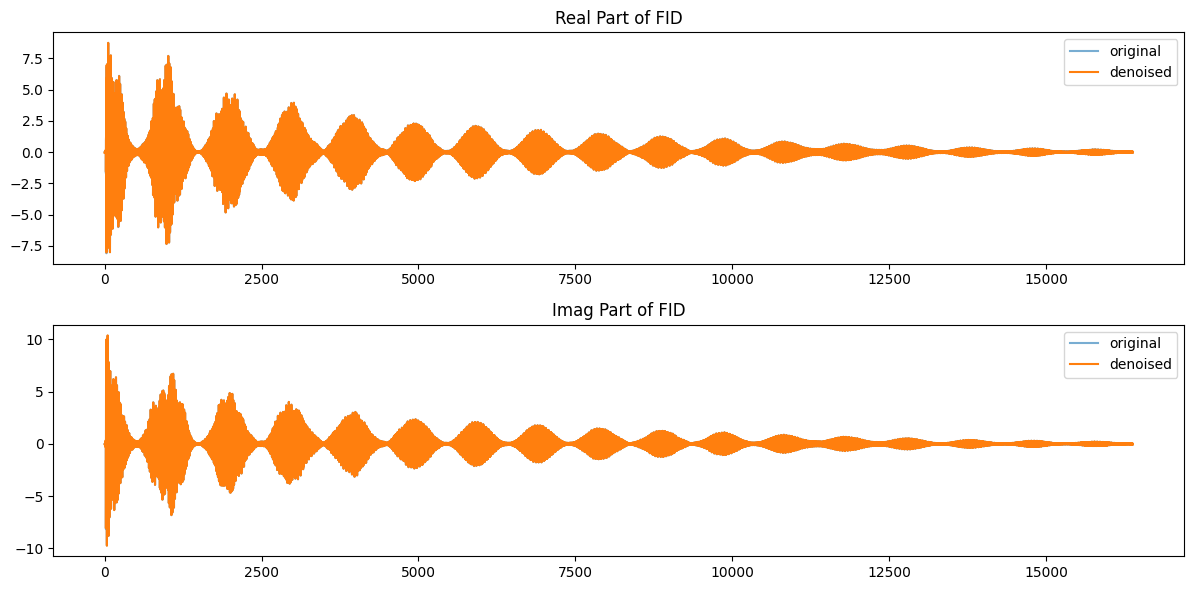

In [ ]:
# --- Upgraded model definition ---
class DilatedResBlock(nn.Module):
    def __init__(self, channels, dilation=1, k=11):
        super().__init__()
        pad = dilation * ((k - 1) // 2)
        self.conv1 = nn.Conv1d(channels, channels, k, padding=pad, dilation=dilation)
        self.conv2 = nn.Conv1d(channels, channels, k, padding=pad, dilation=dilation)

    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = self.conv2(h)
        return F.relu(x + h)

class DenoiseNet(nn.Module):
    def __init__(self, in_ch=2, hidden=64, k=11, dilations=(1,2,4,8,16,32,64)):
        super().__init__()
        self.inp = nn.Conv1d(in_ch, hidden, k, padding=(k-1)//2)
        self.blocks = nn.Sequential(*[DilatedResBlock(hidden, d, k) for d in dilations])
        self.out = nn.Conv1d(hidden, in_ch, k, padding=(k-1)//2)

    def forward(self, x):
        h = F.relu(self.inp(x))
        h = self.blocks(h)
        resid = self.out(h)
        return x + resid

def init_weights(m):
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.zeros_(m.bias)

# --- Training (short curriculum) ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenoiseNet().apply(init_weights).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

for ep in range(3):  # quick test run
    running = 0.0
    for _ in range(60):
        x, y = synth_batch(batch_size=8, noise_std=0.05)
        opt.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opt.step()
        running += loss.item()
    print(f"epoch {ep+1}: avg_loss={running/60:.6f}")

# --- Apply to your real FID ---
model.eval()
with torch.no_grad():
    denoised = model(fid_tensor.to(device)).cpu()

# --- Plot real vs denoised ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title("Real Part of FID")
plt.plot(fid_tensor[0,0].numpy(), label="original", alpha=0.6)
plt.plot(denoised[0,0].numpy(), label="denoised", lw=1.5)
plt.legend()

plt.subplot(2,1,2)
plt.title("Imag Part of FID")
plt.plot(fid_tensor[0,1].numpy(), label="original", alpha=0.6)
plt.plot(denoised[0,1].numpy(), label="denoised", lw=1.5)
plt.legend()
plt.tight_layout()
plt.show()
feat(nmr-dl): FID denoising with dilated Conv1D, curriculum, AMP + chemist-facing math/docs

Summary
- Load FID, per-channel normalize, convert to torch tensor (batch=1, channels=2 [real, imag], length=L).
- Implement DenoiseNet (residual dilated Conv1D blocks), parameter/RF inspection, and shape checks.
- Synthetic FID generator (damped sinusoids) for supervised training.
- Curriculum training (noise σ: 0.10 → 0.03), OneCycleLR (safe fallback), AMP (GPU/CPU), cuDNN benchmark.
- Per-epoch validation vs noisy baseline with ΔSNR metric; tiny-batch overfit diagnostic.
- Apply model to real FID; plot original vs denoised (real/imag).
- Optional larger model (hidden=64, k=11, dilations up to 64) for capacity.

Chemist-facing math and assumptions
- FID model: x(t) = Σ_k A_k e^{-t/T2,k} cos(2π f_k t + φ_k) + n(t), with additive noise n(t) ~ N(0, σ^2).
- Normalization (per channel): x̂ = (x − μ) / (σ + 1e−8) to stabilize training.
- Denoising objective (per-sample MSE): MSE = (1/N) ||ŷ − y||^2, where y = clean FID, ŷ = model(x_noisy).
- SNR improvement we print: ΔSNR_dB = 20·log10(RMSE_noisy / RMSE_model). For σ=0.03, noise variance ≈ σ^2 = 0.0009.
- Conv1D parameters: weights shape (C_out, C_in, K); params = C_out·C_in·K (+C_out if bias).
- Dilation receptive field: K_eff = D·(K−1)+1; cumulative RF adds (K_eff−1) per conv layer.
- Residual learning: output = x + F(x); network learns “correction,” preserving peaks/phase structure.

Problems encountered and fixes
- Training appeared “no improvement” (ΔSNR ≈ 0 dB):
  - Cause: model reinitialized between cells or too few steps at target noise.
  - Fix: curriculum (σ: 0.10 → 0.03), longer loops, optional scheduler; overfit diagnostic confirms gradients flow.
- Slow iteration on CPU/notebook:
  - Fix: shorter crops (e.g., 2048), fewer steps per epoch, AMP, cuDNN benchmark; optional GPU if available.
- Risk of accidental reinit in notebook (model cell redefines weights):
  - Fix: avoid rerunning init cells mid-training; optionally add a “model init guard” or move training to a script.

Where chemists/instructor can help
- Provide representative acquisition parameters (spectrometer freq, dwell time, expected T2 ranges, phase):
  - Improves simulator fidelity (τ/T2, frequency ranges), making training closer to real FIDs.
- Curate small paired datasets: raw FID ↔ cleaned/reference (e.g., long-acquisition or ensemble-averaged FIDs):
  - Enables fine-tuning and objective benchmarking beyond synthetic signals.
- Domain constraints: acceptable smoothing vs peak integrity; phase correction conventions; expected line shapes.
  - Helps define loss weighting (e.g., frequency-domain penalties) and validation metrics aligned with chemistry goals.

Future scaling and reliability
- Promote notebook code into train.py with argparse configs; log to TensorBoard/CSV; early stopping + checkpoints.
- Add model init guard/checkpoint resume to avoid reinit between cells; seed for reproducibility.
- Increase capacity/depth if plateauing (hidden=64+, more dilations) and validate on multiple σ.
- Add frequency-domain validation (FFT of denoised FID → peak metrics: SNR, linewidth, area conservation).
- Package dependencies (requirements.txt) and use a virtual environment for reproducibility.

Files affected
- deep_learning_model.ipynb (model, training, validation, plots, diagnostics)

Notes
- Be mindful: in the “Upgraded model” block, `model = DenoiseNet().apply(init_weights)` reinitializes weights; don’t run after training unless intentional.